# LSTM track finder for 2D toy data in PyTorch

Here, I'm going to get familiar with PyTorch by reproducing the models in LSTM_Toy2D.ipynb.

In [1]:
# Select a GPU first
cuda = True
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from __future__ import print_function

from timeit import default_timer as timer
from functools import partial

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from data import generate_straight_tracks, generate_uniform_noise, generate_track_bkg
from drawing import draw_2d_event, draw_2d_input_and_pred

%matplotlib notebook

In [3]:
torch.__version__

'0.2.0_2'

## Prepare some data

In [4]:
# Detector parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
seed_size = 5

# Data config
n_bkg_tracks = 5
noise_prob = 0

In [5]:
def generate_data(num_events, det_shape, num_bkg_tracks, noise_prob,
                  seed_size=0, binary=True):
    # Generate signal tracks
    sig_tracks = generate_straight_tracks(num_events, det_shape).astype(np.float32)
    # Generate track background
    bkg_tracks = generate_track_bkg(num_events, det_shape,
                                    tracks_per_event=num_bkg_tracks,
                                    skip_layers=seed_size).astype(np.float32)
    # Generate noise background
    noise = generate_uniform_noise(num_events, det_shape,
                                   prob=noise_prob).astype(np.float32)
    # Combine into full events
    events = sig_tracks + bkg_tracks + noise
    if binary:
        events[events > 1] = 1

    return events, sig_tracks

## LSTM simple pixel classifier

This is the traditional model we've done before in keras, but now in pytorch.

In [109]:
# CUDA memory allocations
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_to_np = lambda x: x.cpu().data.numpy()

In [110]:
class LSTMTrackFinder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_lstm_layers=1):
        super(LSTMTrackFinder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        input_size = x.size()
        # Initialize the lstm hidden state
        h = (create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size),
             create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size))
        x, h = self.lstm(x, h)
        # Flatten layer axis into batch axis so FC applies independently across layers.
        x = self.fc(x.contiguous().view(-1, x.size(-1))).view(input_size)
        return x

In [111]:
def cost_function(logits, labels):
    # Flatten the batch and detector layer dimensions
    flat_logits = logits.view(-1, logits.size(-1))
    flat_labels = labels.view(-1)
    return F.cross_entropy(flat_logits, flat_labels)

def logits_to_probs(logits):
    size = logits.size()
    return F.softmax(logits.view(-1, size[-1])).view(size)

def batch_generator(**kwargs):
    while True:
        events, tracks = generate_data(**kwargs)
        inputs = np_to_torch(events)
        labels = np_to_torch(tracks.argmax(axis=2))
        yield inputs, labels

def train_step(model, inputs, targets, optimizer, cost_func):
    model.zero_grad()
    outputs = model(inputs)
    loss = cost_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def calc_accuracy(outputs, labels):
    matches = (outputs.max(dim=2)[1] == labels)
    return matches.data.sum() / float(labels.numel())

In [112]:
# Model config
hidden_dim = 200
n_lstm_layers = 1

# Train config
n_epochs = 64
n_batches = 512
batch_size = 128

In [113]:
epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

65536 samples per epoch
4194304 total samples for training


In [ ]:
%%time
# Create the model and optimizer
model = LSTMTrackFinder(det_width, hidden_dim, n_lstm_layers=n_lstm_layers)
optimizer = torch.optim.Adam(model.parameters())

if cuda: model.cuda()
print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

LSTMTrackFinder (
  (lstm): LSTM(50, 200, batch_first=True)
  (fc): Linear (200 -> 50)
)
Parameters: 211650
CPU times: user 2min 37s, sys: 320 ms, total: 2min 38s
Wall time: 2min 38s


In [ ]:
# Training set batcher
train_batcher = batch_generator(
    num_events=batch_size, det_shape=det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_input, batch_labels = next(train_batcher)
        sum_loss += train_step(model, batch_input, batch_labels, optimizer, cost_function)
    
    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 2.005 time 14.6871s
Epoch 1
  average loss 0.793 time 14.6538s
Epoch 2
  average loss 0.500 time 14.6512s
Epoch 3
  average loss 0.384 time 14.6326s
Epoch 4
  average loss 0.334 time 14.6168s
Epoch 5
  average loss 0.292 time 14.6028s
Epoch 6
  average loss 0.272 time 14.6052s
Epoch 7
  average loss 0.256 time 14.685s
Epoch 8
  average loss 0.238 time 14.6463s
Epoch 9
  average loss 0.227 time 14.6016s
Epoch 10
  average loss 0.221 time 14.6455s
Epoch 11
  average loss 0.211 time 14.6321s
Epoch 12
  average loss 0.201 time 14.6299s
Epoch 13
  average loss 0.202 time 14.5989s
Epoch 14
  average loss 0.192 time 14.5787s
Epoch 15
  average loss 0.186 time 14.5728s
Epoch 16
  average loss 0.180 time 14.5807s
Epoch 17
  average loss 0.176 time 14.6066s
Epoch 18
  average loss 0.173 time 14.6244s
Epoch 19
  average loss 0.171 time 14.6193s
Epoch 20
  average loss 0.161 time 14.6607s
Epoch 21
  average loss 0.144 time 14.9066s
Epoch 30
  average loss 0.143 time 14.8999s

<IPython.core.display.Javascript object>


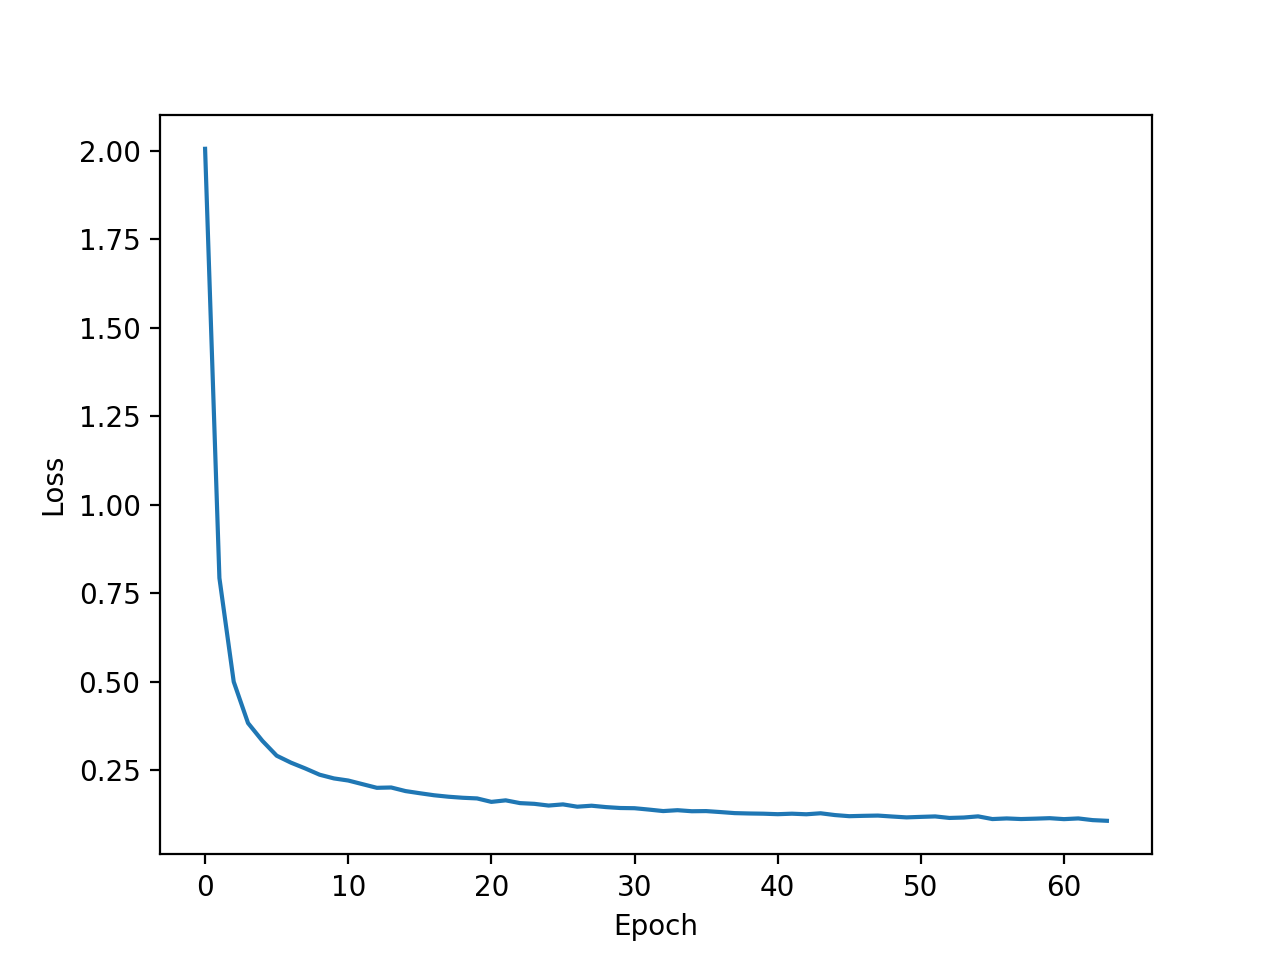

In [117]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

### Evaluate a test set

In [118]:
# Generate a test set
n_test = 10240
test_events, test_tracks = generate_data(
    n_test, det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)
test_input = np_to_torch(test_events)
test_labels = np_to_torch(test_tracks.argmax(axis=2))

In [119]:
# Calculate test set metrics
model.eval()
test_logits = model(test_input)
test_preds = logits_to_probs(test_logits)
test_loss = cost_function(test_logits, test_labels)

print('Final test loss', test_loss.data[0])
print('Pixel classification accuracy', calc_accuracy(test_preds, test_labels))
print('Hit classification accuracy', calc_accuracy(test_preds * test_input, test_labels))

Final test loss 0.101662121713
Pixel classification accuracy 0.961166015625
Hit classification accuracy 0.96121875


<IPython.core.display.Javascript object>


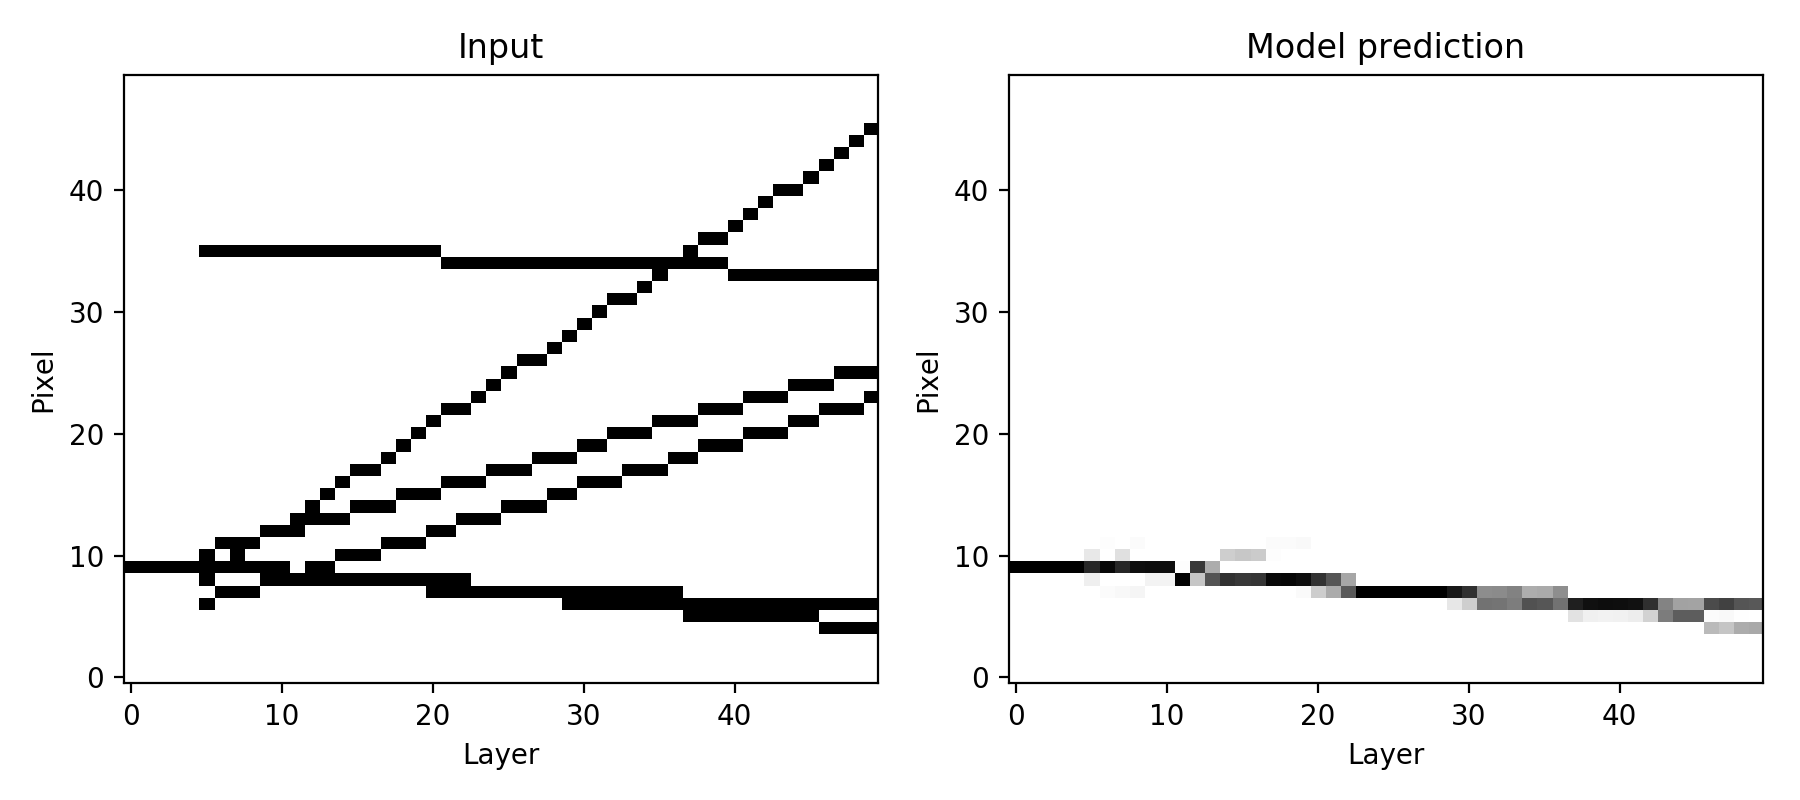

<IPython.core.display.Javascript object>


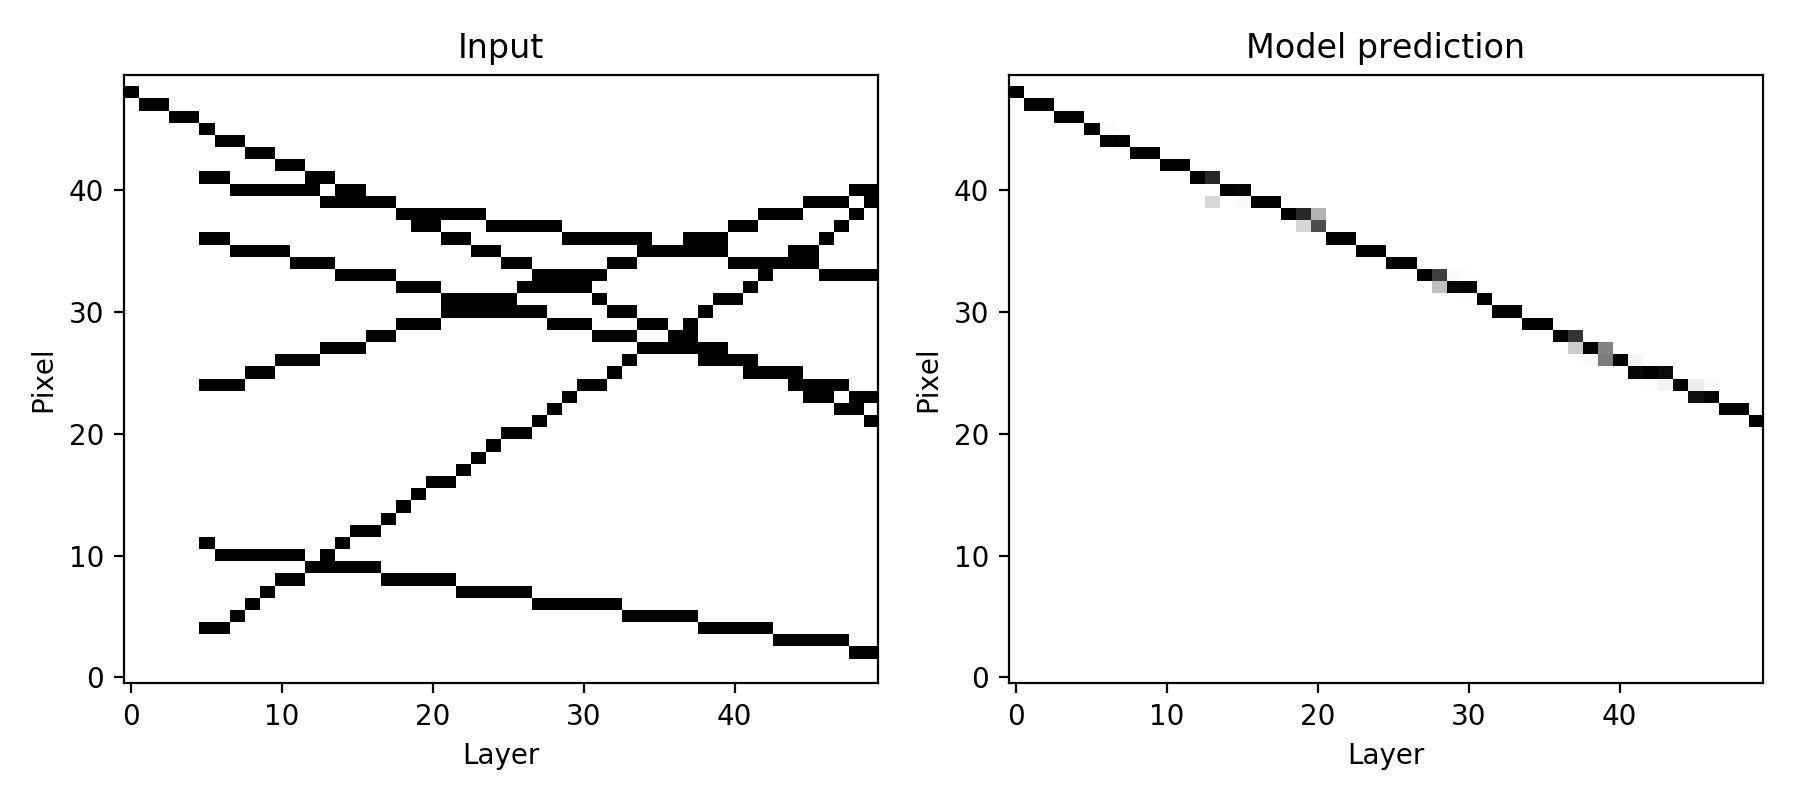

<IPython.core.display.Javascript object>


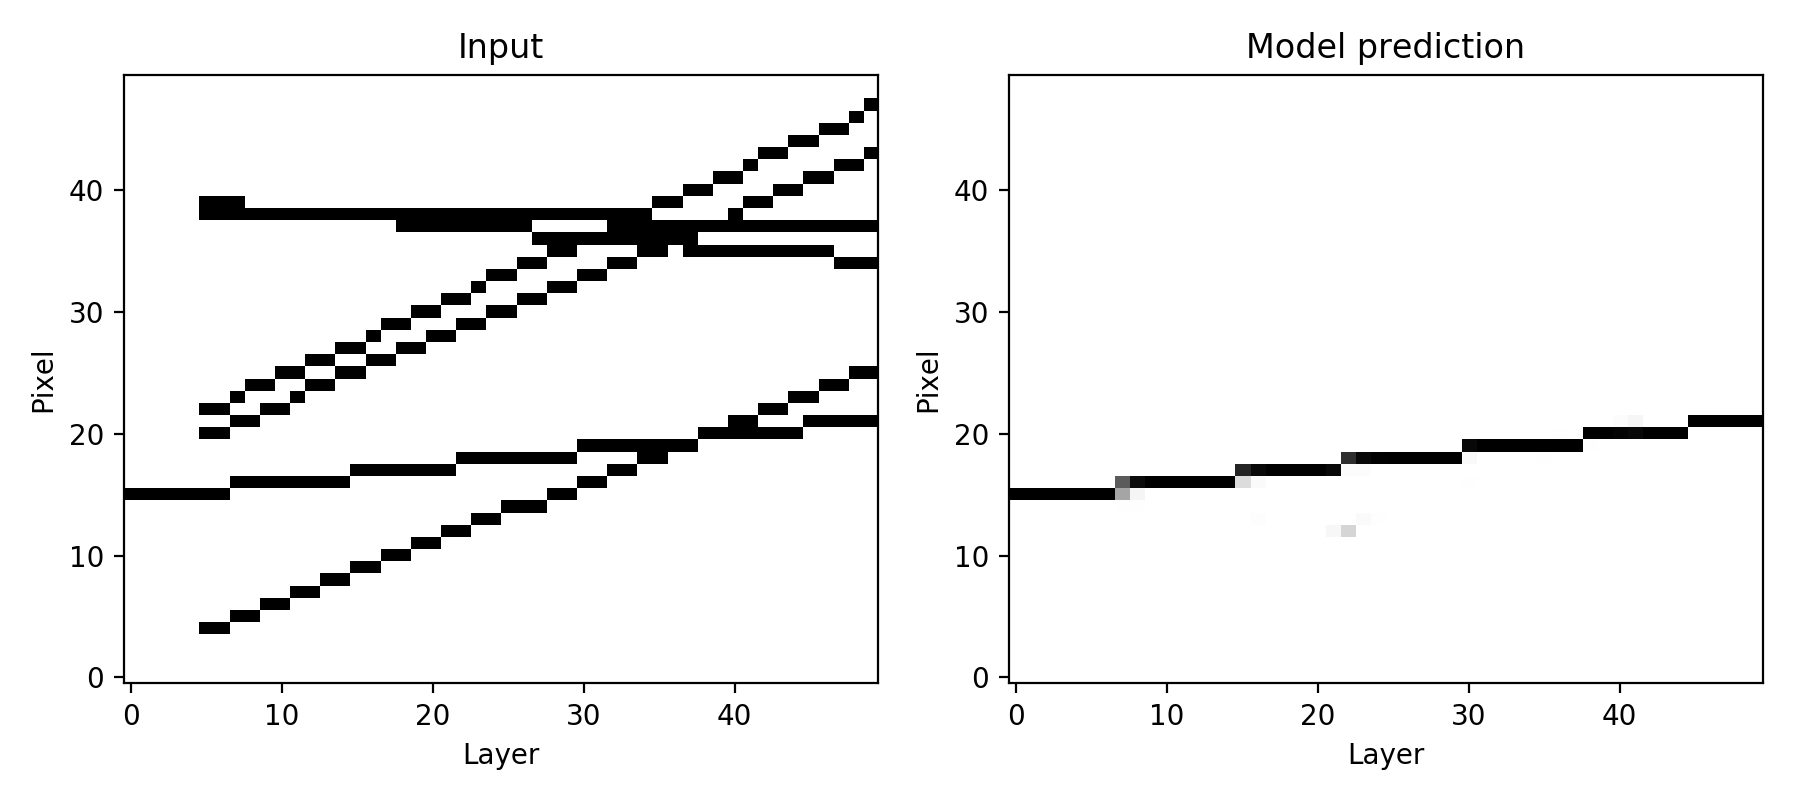

In [120]:
# Draw an event
for i in [0, 1, 2]:
    draw_2d_input_and_pred(test_events[i], torch_to_np(test_preds[i]), cmap='gray_r');

## Filter model

New approach. In this model, at each layer the data is combined with a prior guess (from the seed or from extrapolation) to improve its state estimate. The output is split into a decoder which gives the final prediction on the current layer, and an extrapolator which produces the guess for the next layer.

In [14]:
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x, volatile=False: Variable(torch.from_numpy(x), volatile=volatile).cuda()
torch_to_np = lambda x: x.cpu().data.numpy()

In [71]:
# Let's try something minor here: remove the input linear op. The lSTM can do that.
class FilterTracker(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(FilterTracker, self).__init__()
        self.lstm = nn.LSTMCell(input_dim*2, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.extrapolator = nn.Linear(hidden_dim, input_dim)
    
    def init_hidden_state(self, batch_size):
        return (create_tensor_var(batch_size, self.lstm.hidden_size),
                create_tensor_var(batch_size, self.lstm.hidden_size))
    
    def step(self, x, prior, h, c):
        """Encode data and prior and iterate the LSTM"""
        return self.lstm(torch.cat([x, prior], dim=1), (h, c))
    
    def forward(self, inputs):
        x, seed = inputs
        input_size = x.size()
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(input_size[0])
        # Two sets of outputs: forward-predictions and final-predictions
        fwd_preds, fin_preds = [seed[:,0]], []
        
        # Loop over seed layers
        for i in range(seed.size(1)):
            # Iterate the model using the seed as the prior
            h, c = self.step(x[:,i], seed[:,i], h, c)
            fin_preds.append(self.decoder(h))
            fwd_preds.append(self.extrapolator(h))
        
        # Loop over layers until last
        for i in range(seed.size(1), input_size[1] - 1):
            # Iterate the model using the forward-prediction as prior
            #prior = F.softmax(fwd_preds[-1])
            prior = fwd_preds[-1]
            h, c = self.step(x[:,i], prior, h, c)
            fin_preds.append(self.decoder(h))
            fwd_preds.append(self.extrapolator(h))
        
        # Handle final layer; no extrapolation needed
        #prior = F.softmax(fwd_preds[-1])
        prio = fwd_preds[-1]
        h, c = self.step(x[:,-1], prior, h, c)
        fin_preds.append(self.decoder(h))
        
        # Stack the outputs together
        return torch.stack(fwd_preds, dim=1), torch.stack(fin_preds, dim=1)

In [72]:
def cost_function(outputs, labels, loss_weights):
    # Flatten the batch and detector layer dimensions
    flat_logits = [o.view(-1, o.size(-1)) for o in outputs]
    labels = labels.view(-1)
    # Compute the losses and sum them
    losses = [F.cross_entropy(l, labels) for l in flat_logits]
    return sum(loss*w for (loss, w) in zip(losses, loss_weights))

def logits_to_probs(logits):
    size = logits.size()
    return F.softmax(logits.view(-1, size[-1])).view(size)

def batch_generator(seed_size, **kwargs):
    while True:
        events, tracks = generate_data(**kwargs)
        inputs = np_to_torch(events)
        seeds = np_to_torch(tracks[:,:seed_size])
        labels = np_to_torch(tracks.argmax(axis=2))
        yield (inputs, seeds), labels
        
def train_step(model, inputs, targets, optimizer, cost_func):
    model.zero_grad()
    outputs = model(inputs)
    loss = cost_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def calc_accuracy(outputs, labels):
    matches = (outputs.max(dim=2)[1] == labels)
    return matches.data.sum() / float(labels.numel())

In [97]:
# Model config
hidden_dim = 200

# Train config
n_epochs = 64
n_batches = 512
batch_size = 256
fwd_frac = 0.5
loss_weights = [fwd_frac, 1 - fwd_frac]

epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

131072 samples per epoch
8388608 total samples for training


In [98]:
%%time

# Create the model and optimizer
model3 = FilterTracker(det_width, hidden_dim)
optimizer = torch.optim.Adam(model3.parameters())

if cuda: model3.cuda()
print(model3)
print('Parameters:', sum(param.numel() for param in model3.parameters()))

FilterTracker (
  (lstm): LSTMCell(100, 200)
  (decoder): Linear (200 -> 50)
  (extrapolator): Linear (200 -> 50)
)
Parameters: 261700
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.38 ms


In [ ]:
# Training set batcher
train3_batcher = batch_generator(
    num_events=batch_size, det_shape=det_shape, seed_size=seed_size,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)

losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_input, batch_labels = next(train3_batcher)
        sum_loss += train_step(model3, batch_input, batch_labels, optimizer,
                               partial(cost_function, loss_weights=loss_weights))

    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 2.694 time 52.8061s
Epoch 1
  average loss 1.804 time 52.3768s
Epoch 2
  average loss 1.311 time 52.3909s
Epoch 3
  average loss 1.028 time 52.2145s
Epoch 4
  average loss 0.898 time 52.4108s
Epoch 5
  average loss 0.791 time 53.114s
Epoch 6
  average loss 0.745 time 54.0057s
Epoch 7
  average loss 0.703 time 53.9701s
Epoch 8
  average loss 0.627 time 54.0059s
Epoch 9
  average loss 0.515 time 53.5869s
Epoch 14
  average loss 0.488 time 52.9615s
Epoch 15
  average loss 0.470 time 53.0238s
Epoch 16
  average loss 0.464 time 52.9501s
Epoch 17
  average loss 0.461 time 53.2692s
Epoch 18
  average loss 0.478 time 52.9164s
Epoch 19
  average loss 0.489 time 52.9178s
Epoch 20
  average loss 0.554 time 52.6543s
Epoch 21
  average loss 0.507 time 52.4831s
Epoch 22
  average loss 0.446 time 52.2058s
Epoch 23
  average loss 0.427 time 52.1595s
Epoch 24
  average loss 0.419 time 52.5606s
Epoch 25
  average loss 0.415 time 53.506s
Epoch 26
  average loss 0.414 time 53.2592s


<IPython.core.display.Javascript object>


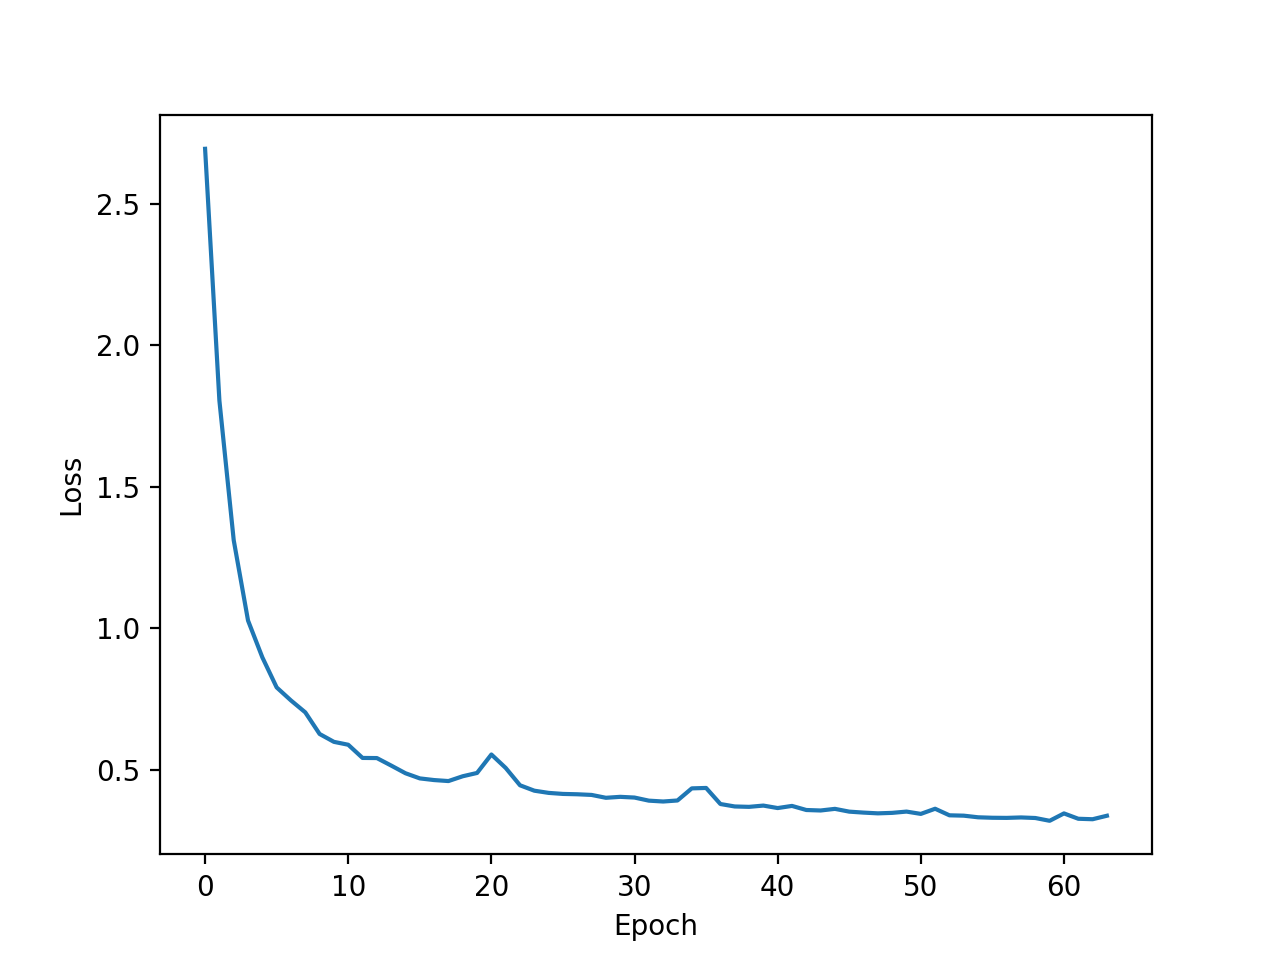

In [101]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [102]:
# Generate a new test set
n_test = 10240
test3_events, test3_tracks = generate_data(
    n_test, det_shape, seed_size=0,
    num_bkg_tracks=n_bkg_tracks, noise_prob=noise_prob)
test3_input = np_to_torch(test3_events, volatile=True)
test3_seeds = np_to_torch(test3_tracks[:,:seed_size], volatile=True)
test3_labels = np_to_torch(test3_tracks.argmax(axis=2), volatile=True)

In [103]:
# Inference mode supposedly consumes less memory
model3.eval()

# Calculate test set predictions and loss
test3_outputs = model3([test3_input, test3_seeds])
test3_probs = [logits_to_probs(outputs) for outputs in test3_outputs]
test3_loss = cost_function(test3_outputs, test3_labels, loss_weights)
print('Test set loss', test3_loss.data[0])

# Compute forward prediction accuracy
print('Forward prediction accuracies')
print('  pixel', calc_accuracy(test3_probs[0], test3_labels))
print('  hit  ', calc_accuracy(test3_input * test3_probs[0], test3_labels))

print('Final prediction accuracies')
print('  pixel', calc_accuracy(test3_probs[1], test3_labels))
print('  hit  ', calc_accuracy(test3_input * test3_probs[1], test3_labels))

Test set loss 0.325716018677
Forward prediction accuracies
  pixel 0.826560546875
  hit   0.9500625
Final prediction accuracies
  pixel 0.954669921875
  hit   0.955404296875


<IPython.core.display.Javascript object>


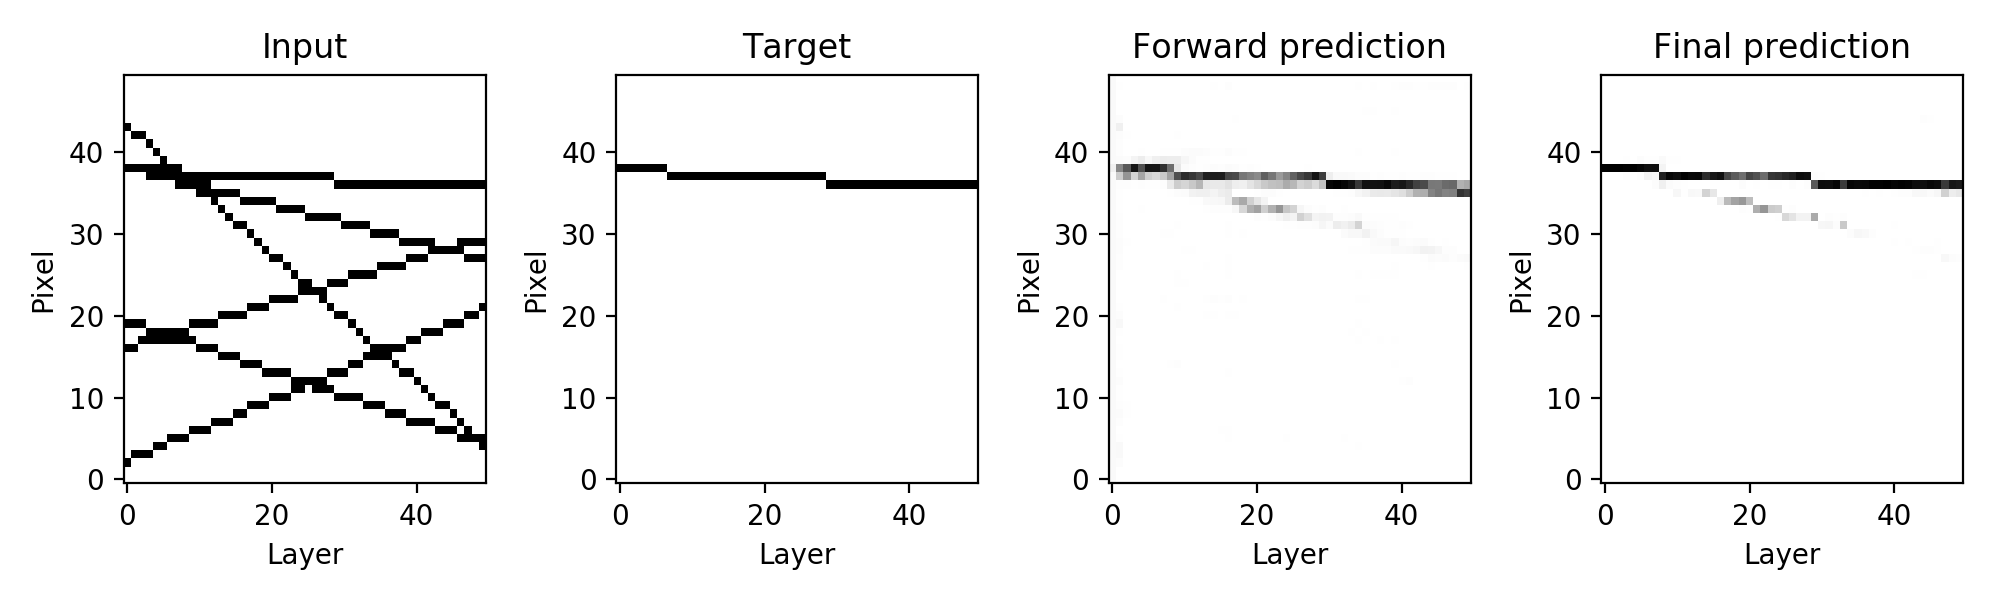

<IPython.core.display.Javascript object>


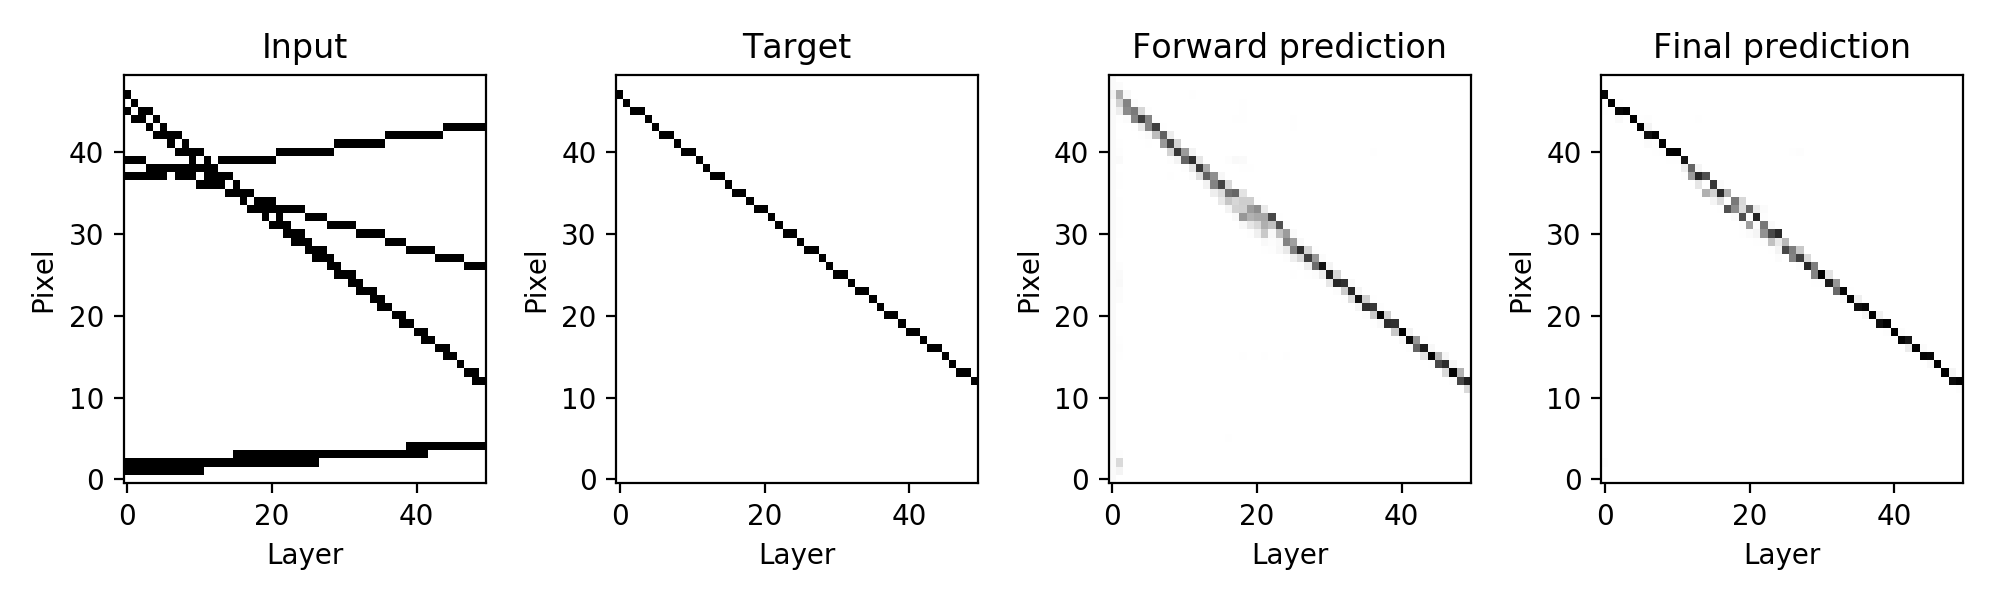

<IPython.core.display.Javascript object>


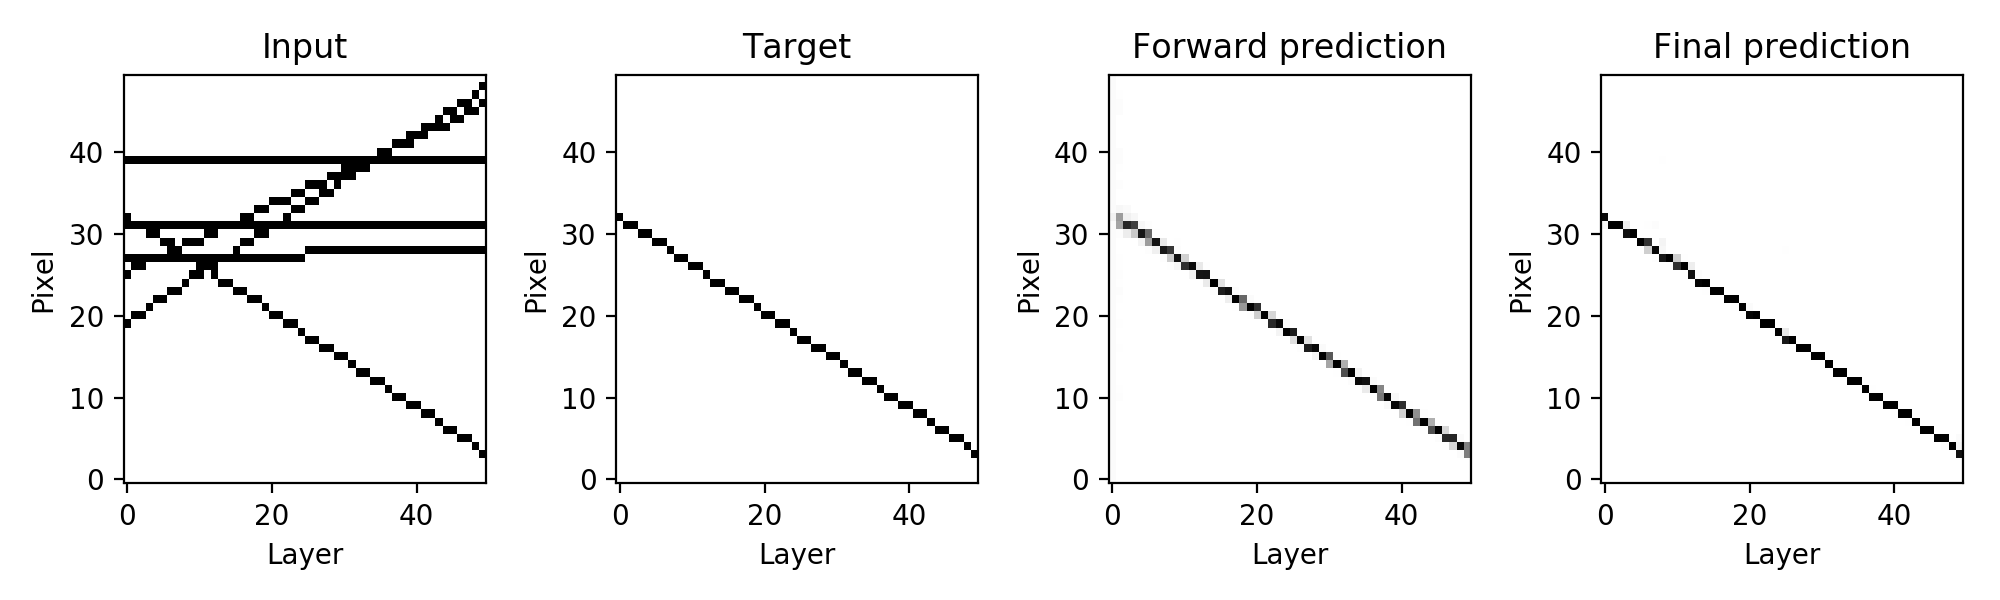

In [104]:
for i in [0, 1, 2]:
    plt.figure(figsize=(10,3))
    plt.subplot(141)
    draw_2d_event(test3_events[i], title='Input', cmap='gray_r')
    plt.subplot(142)
    draw_2d_event(test3_tracks[i], title='Target', cmap='gray_r')
    plt.subplot(143)
    draw_2d_event(torch_to_np(test3_probs[0][i]), title='Forward prediction', cmap='gray_r')
    plt.subplot(144)
    draw_2d_event(torch_to_np(test3_probs[1][i]), title='Final prediction', cmap='gray_r')

### Discussion

This model can clearly learn and perform well on this toy data, but it takes a _lot_ of training to get to good performance. Note in the above session it hasn't fully converged. Maybe there are ways to speed it up, but it's a little tough to believe that for a fixed amount of data this model can outperform the simpler lstm model. Still, I think this approach has very nice motivations and might be more useful in more complex scenarios.

This model could be trained in more complicated ways which may improve the experience:
- The loss weights on forward-vs-final prediction could be adjusted during training.
- The extrapolator module could be pre-trained.

## Multi-track model

The above models may already be learning to track all the particles in an event in order to properly resolve ambiguities at track crossings. So, let's see how well a minimal model can correctly predict the bins for all tracks at once.

How to specify the input seed?
- use a separate LSTM for that, one which embeds the seed hits into the cell and hidden state which we use in the prediction lstm.

There are multiple ways to split the model output:
- use a dense layer to spit out each output as a large tensor which I split up
- split it at a hidden layer, then apply a FC to each output to transform to the prediction

In [21]:
# Torch variable conversions
create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()
torch_to_np = lambda x: x.cpu().data.numpy()

In [22]:
class MultiTrackFinder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_tracks):
        super(MultiTrackFinder, self).__init__()
        self.lstm1 = nn.LSTM(input_dim*num_tracks, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim*num_tracks)
    
    def forward(self, inputs):
        x, seeds = inputs
        input_size = x.size()
        # Initialize the LSTM hidden state
        h = (create_tensor_var(1, input_size[0], self.lstm1.hidden_size),
             create_tensor_var(1, input_size[0], self.lstm1.hidden_size))
        
        # Embed the seeds
        _, h = self.lstm1(seeds, h)
        
        # Now do the classification on the remaining layers
        x, h = self.lstm2(x, h)
        
        # Flatten layer and batch axis together
        hidden_size = x.size()
        x = x.contiguous().view(-1, hidden_size[-1])
        # Apply the output FC
        x = self.fc(x).view(hidden_size[0], hidden_size[1], -1)
        
        # Split the predictions by track
        outputs = torch.split(x, self.lstm2.input_size, dim=-1)
        return outputs

In [23]:
def cost_function(logits, labels):
    # Flatten the batch and detector layer dimensions
    flat_logits = [o.contiguous().view(-1, o.size(-1)) for o in logits]
    flat_labels = [l.view(-1) for l in labels]
    # Compute the losses and average them
    losses = [F.cross_entropy(logs, labs) for (logs, labs) in zip(flat_logits, flat_labels)]
    return torch.cat(losses).mean()

def logits_to_probs(logits):
    return [F.softmax(l.contiguous().view(-1, l.size(-1))).view(l.size()) for l in logits]

def batch_generator(n_event, n_tracks, det_shape, seed_size, dtype=np.float32):
    while True:
        tracks = [generate_straight_tracks(n_event, det_shape).astype(np.float32)
                  for i in range(n_tracks)]
        seeds = [t[:,:seed_size] for t in tracks]
        events = sum(tracks)
        inputs = np_to_torch(events[:, seed_size:])
        seeds = np_to_torch(np.concatenate(seeds, axis=2))
        labels = [np_to_torch(t[:, seed_size:].argmax(axis=2)) for t in tracks]
        yield (inputs, seeds), labels

def train_step(model, inputs, targets, optimizer, cost_func):
    model.zero_grad()
    outputs = model(inputs)
    loss = cost_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def calc_accuracy(outputs, labels):
    matches = torch.cat([(o.max(dim=2)[1] == l) for (o, l) in zip(outputs, labels)])
    return matches.data.sum() / float(matches.numel())

In [24]:
# Data config
n_tracks = 5

# Model config
hidden_dim = 200

# Train config
n_epochs = 64
n_batches = 1024
batch_size = 64

epoch_size = n_batches * batch_size
n_samples = n_epochs * epoch_size
print(epoch_size, 'samples per epoch')
print(n_samples, 'total samples for training')

65536 samples per epoch
4194304 total samples for training


In [25]:
%%time

# Create the model and optimizer
model = MultiTrackFinder(det_width, hidden_dim, n_tracks)
optimizer = torch.optim.Adam(model.parameters())

if cuda: model.cuda()
print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

MultiTrackFinder (
  (lstm1): LSTM(250, 200, batch_first=True)
  (lstm2): LSTM(50, 200, batch_first=True)
  (fc): Linear (200 -> 250)
)
Parameters: 613450
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 9.71 ms


In [26]:
# Training set batcher
train_batcher = batch_generator(batch_size, n_tracks, det_shape, seed_size)
losses = []

# Training loop over epochs
for i in range(n_epochs):
    
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    # Loop over batches
    for j in np.arange(n_batches):
        batch_input, batch_labels = next(train_batcher)
        sum_loss += train_step(model, batch_input, batch_labels, optimizer, cost_function)

    end_time = timer()
    avg_loss = sum_loss / n_batches
    losses.append(avg_loss)
    print('  average loss %.3f' % avg_loss, 'time %gs' % (end_time - start_time))

Epoch 0
  average loss 1.886 time 20.3785s
Epoch 1
  average loss 1.208 time 20.2696s
Epoch 2
  average loss 1.042 time 20.2354s
Epoch 3
  average loss 0.917 time 20.2446s
Epoch 4
  average loss 0.805 time 20.2448s
Epoch 5
  average loss 0.712 time 20.2509s
Epoch 6
  average loss 0.639 time 20.2528s
Epoch 7
  average loss 0.590 time 20.2705s
Epoch 8
  average loss 0.549 time 20.2506s
Epoch 9
  average loss 0.516 time 20.2459s
Epoch 10
  average loss 0.494 time 20.3633s
Epoch 11
  average loss 0.468 time 20.4365s
Epoch 12
  average loss 0.451 time 20.3226s
Epoch 13
  average loss 0.434 time 20.4679s
Epoch 14
  average loss 0.421 time 20.4364s
Epoch 15
  average loss 0.408 time 20.2866s
Epoch 16
  average loss 0.396 time 20.3437s
Epoch 17
  average loss 0.381 time 20.2974s
Epoch 18
  average loss 0.372 time 20.2835s
Epoch 19
  average loss 0.367 time 20.2829s
Epoch 20
  average loss 0.355 time 20.1107s
Epoch 21
  average loss 0.349 time 20.1039s
Epoch 22
  average loss 0.342 time 20.2457

<IPython.core.display.Javascript object>


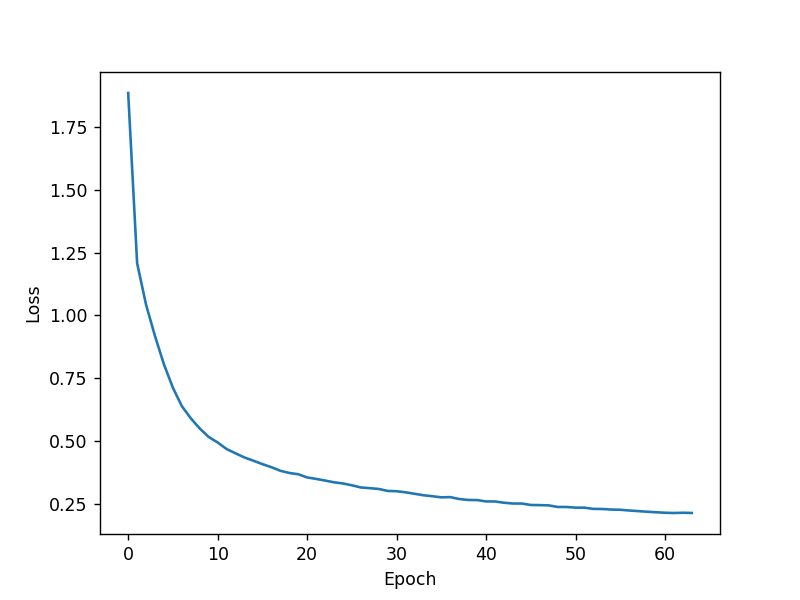

In [27]:
plt.figure()
plt.plot(np.arange(n_epochs), np.array(losses))
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [28]:
# Move to the CPU
create_tensor_var = lambda *size: Variable(torch.FloatTensor(*size).zero_())
np_to_torch = lambda x: Variable(torch.from_numpy(x))
torch_to_np = lambda x: x.cpu().data.numpy()

model.cpu()
model.eval()

MultiTrackFinder (
  (lstm1): LSTM(250, 200, batch_first=True)
  (lstm2): LSTM(50, 200, batch_first=True)
  (fc): Linear (200 -> 250)
)

In [29]:
# Generate a test set
n_test = 10240
test_tracks = [generate_straight_tracks(n_test, det_shape).astype(np.float32)
               for i in range(n_tracks)]
test_seeds = [t[:,:seed_size] for t in test_tracks]
test_events = sum(test_tracks)
test_input = np_to_torch(test_events[:, seed_size:])
test_seeds = np_to_torch(np.concatenate(test_seeds, axis=2))
test_labels = [np_to_torch(t[:, seed_size:].argmax(axis=2)) for t in test_tracks]

In [36]:
# Inference mode supposedly consumes less memory
model.eval()

# Calculate test set predictions and loss
test_outputs = model([test_input, test_seeds])
test_probs = logits_to_probs(test_outputs)
test_loss = cost_function(test_outputs, test_labels)
# FIXME: this weights bins higher with content > 1
test_masked_probs = [p * test_input for p in test_probs]
print('Test set loss', test_loss.data[0])

# Compute accuracy
print('Prediction accuracies')
print('  pixel', calc_accuracy(test_probs, test_labels))
print('  hit  ', calc_accuracy(test_masked_probs, test_labels))

Test set loss 0.208659261465
Prediction accuracies
  pixel 0.920552951389
  hit   0.920083767361


<IPython.core.display.Javascript object>


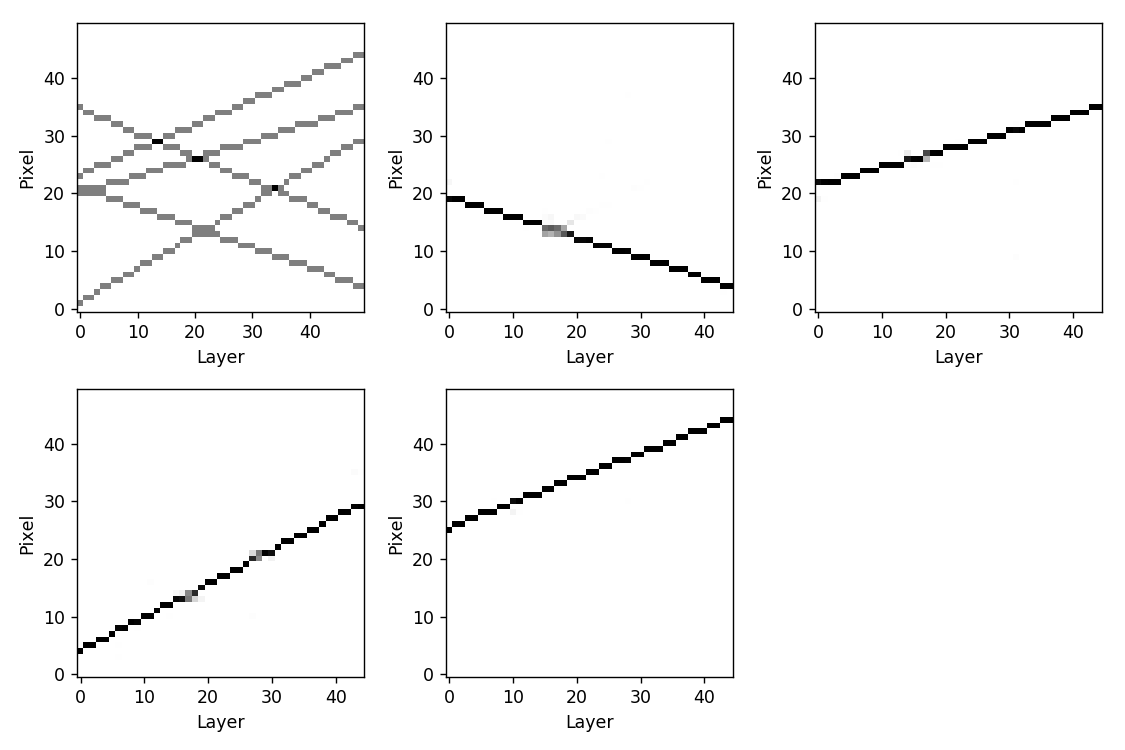

In [37]:
i = 1
plt.figure(figsize=(9,6))
plt.subplot(231)
draw_2d_event(test_events[i], cmap='gray_r')
plt.subplot(232)
draw_2d_event(torch_to_np(test_probs[0])[i], cmap='gray_r')
plt.subplot(233)
draw_2d_event(torch_to_np(test_probs[1])[i], cmap='gray_r')
plt.subplot(234)
draw_2d_event(torch_to_np(test_probs[2])[i], cmap='gray_r')
plt.subplot(235)
draw_2d_event(torch_to_np(test_probs[3])[i], cmap='gray_r')
plt.tight_layout()